In [1]:
from pyramid.arima import auto_arima
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

/home/veronika/.virtualenvs/idsc-2019/lib/python3.5/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [2]:
%run setup_workspace.ipynb # loads data

In [3]:
data = daily_energy_consumption
data.ds.min(), data.ds.max()

(datetime.date(2011, 1, 1), datetime.date(2018, 8, 3))

In [4]:
data.tail()

ds         y
2767  2018-07-30  296519.0
2768  2018-07-31  295933.0
2769  2018-08-01  307690.0
2770  2018-08-02  329641.0
2771  2018-08-03   13335.0

# Creating a SARIMA model

## 1. Train-test-split

In [5]:
split_date = date(2016,1,1)
min_date = date(2013,1,1)
max_date = date(2017,1,1)

train = data[data.ds < split_date]
test = data[data.ds > split_date]

if min_date is not None:
    train = train[train['ds'] > min_date]
if max_date is not None:
    test = test[test['ds'] < max_date]

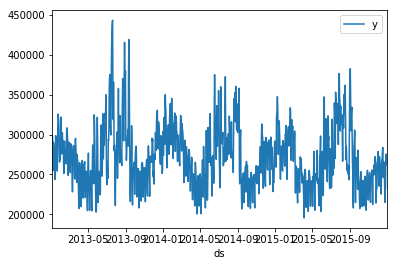

In [6]:
train.set_index('ds').plot()

In [7]:
# # Plot
# fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# # Usual Differencing
# axes[0].plot(train.y[:], label='Original Series')
# axes[0].plot(train.y[:].diff(1), label='Usual Differencing')
# axes[0].set_title('Usual Differencing')
# axes[0].legend(loc='upper left', fontsize=10)


# # Seasinal Dei
# axes[1].plot(train.y[:], label='Original Series')
# axes[1].plot(train.y[:].diff(365), label='Seasonal Differencing', color='green')
# axes[1].set_title('Seasonal Differencing')
# plt.legend(loc='upper left', fontsize=10)
# plt.suptitle('Candy Production Index', fontsize=16)
# plt.show()

## 2. Model training

In [8]:
%%time 

# Seasonal - fit stepwise auto-ARIMA
smodel = auto_arima(train.y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=round((365)),
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 365); AIC=17444.088, BIC=17453.272, Fit time=79.627 seconds


KeyboardInterrupt: 

## 3. Forecast

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=len(test.ds), return_conf_int=True)

In [ ]:
# make series for plotting purpose
index_of_fc = test.ds
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# # Plot
plt.figure(figsize=(14,8))
plt.plot(train.set_index('ds').tail(70), linewidth=2, color = '#0092BC')
plt.plot(test.set_index('ds'), linewidth=2, color = '#0092BC')
plt.plot(fitted_series, color='#265F7F', linewidth=2)
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Forecast - Candy Production Index")
plt.show()

In [ ]:
tmp = test.copy()
tmp['yhat'] = fitted_series.values
tmp.set_index('ds', drop=True).plot()

## 4. Evaluation

In [ ]:
error = mean_absolute_percentage_error(test.y, fitted_series.values)
print('MAPE:%0.2f%%'%error)